In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import tams

import seaborn as sns
import ptitprince as pt
import pandas as pd

## Load data

In [4]:
data = tams.load_example_mpas()
tb = data.tb.isel(time=slice(2,None))

## Identify cloud elements (CEs)

In [13]:
times_ = tb.time.values
# contour_sets = [tams.identify(tb.sel(time=time)) for time in times]
contour_sets = []
times = []
for time in times_:
    try:
        cs = tams.identify(tb.sel(time=time))
    except Exception as e:
        print("Error", time, e)
    else:
        contour_sets.append(cs)
        times.append(time)

46.9%  of 235s are big enough
32.0% of big-enough 235s have enough 219 area
38.0%  of 235s are big enough
54.4% of big-enough 235s have enough 219 area
34.3%  of 235s are big enough
45.8% of big-enough 235s have enough 219 area
34.4%  of 235s are big enough
38.1% of big-enough 235s have enough 219 area
32.0%  of 235s are big enough
47.7% of big-enough 235s have enough 219 area
35.5%  of 235s are big enough
38.5% of big-enough 235s have enough 219 area
32.6%  of 235s are big enough
43.7% of big-enough 235s have enough 219 area
30.9%  of 235s are big enough
41.8% of big-enough 235s have enough 219 area
30.4%  of 235s are big enough
32.4% of big-enough 235s have enough 219 area
27.5%  of 235s are big enough
34.8% of big-enough 235s have enough 219 area
28.6%  of 235s are big enough
33.8% of big-enough 235s have enough 219 area
25.1%  of 235s are big enough
26.2% of big-enough 235s have enough 219 area
29.1%  of 235s are big enough
22.7% of big-enough 235s have enough 219 area
24.6%  of 23

## Track CE groups between times

In [14]:
cs = tams.track(contour_sets, times, u_projection=-5)

/glade/u/home/knocasio/git/TAMS/tams.py:399: UserWarning: unequal time spacing
  warnings.warn("unequal time spacing")


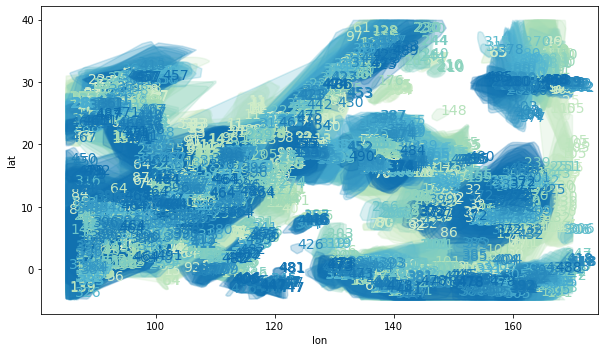

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set(xlabel="lon", ylabel="lat")

colors = plt.cm.GnBu(np.linspace(0.2, 0.85, len(times)))

# Plot blobs at each time
for i, g in cs.groupby("itime"):
    color = colors[i]

    g.plot(ax=ax, facecolor=color, edgecolor=color, alpha=0.25, lw=1.5)

    # Label blobs with assigned ID
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.",
        )
        for id_, x, y in zip(g.id, g.centroid.x, g.centroid.y):
            ax.text(x, y, id_, c=color, fontsize=14, zorder=10)


fig.tight_layout()

## Classify

In [16]:
classes = cs.groupby("id").apply(tams.classify)
cs["class"] = cs.id.map(classes)

### Define a variable that groups by id the classes to plot by number of MCSs

In [17]:
c = pd.DataFrame({"class": classes})

# Plots/ Data Visualization

## Number of MCSs by Class 

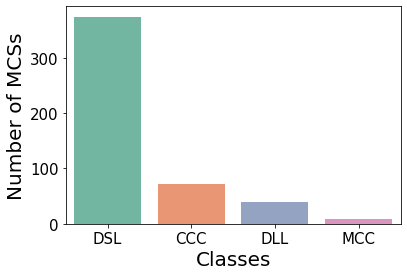

In [19]:
pal = "Set2"
ax = sns.countplot(x="class", data=c, palette=pal)
ax.set_xlabel("Classes", fontsize = 20)
ax.set_ylabel("Number of MCSs", fontsize = 20)
ax.tick_params(labelsize=15)

## MCSs Area Distribution

Text(0, 0.5, 'MCSs Area [km$^2$]')

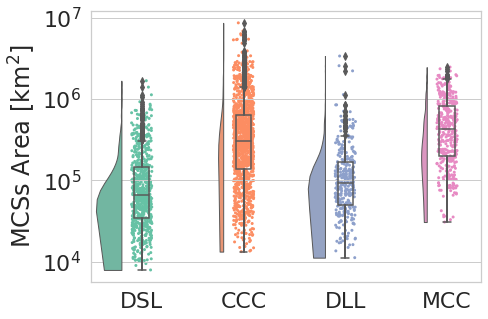

In [20]:
dx = list(cs["class"]); dy = list(cs["area_km2"]); ort = "v"; pal = "Set2";
sns.set(style="whitegrid",font_scale=2)
f, ax = plt.subplots(figsize=(7, 5))
pt.RainCloud(x=dx,y=dy,data=cs, palette = pal, width_viol = .5, ax = ax, orient = ort)
plt.yscale("log")
plt.ylabel('MCSs Area [km$^2$]')

In [57]:
#cs.area_km2.hist(bins=30); plt.gca().set_xscale("log")

## MCSs Duration Distribtuion

### Define a variable that computes the duration for each MCS (because it is CE data and hourly outputs unique works)

In [21]:
durations = cs.groupby("id").apply(lambda g: g.time.unique().size)
durations.name = "duration"
#durations.plot.hist()

# Make use of the variable c which groups by class to be able to plot by class
c["duration"] = durations

### Split c by organized and disorganized classes

In [32]:
c2 = c[c["class"].isin(["MCC", "CCC"])]
c3 = c[c["class"].isin(["DLL", "DSL"])]

Text(0.5, 0, 'MCSs Duration [hr]')

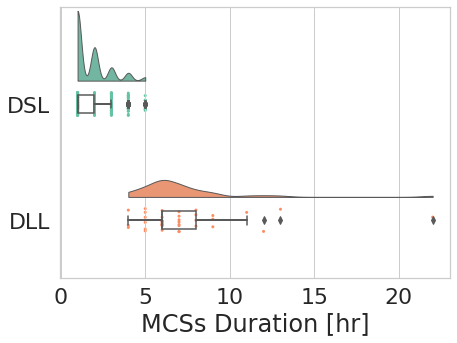

In [43]:
dx = list(c3["class"]); dy = list(c3["duration"]); ort = "h"; pal = "Set2";
sns.set(style="whitegrid",font_scale=2)
f, ax = plt.subplots(figsize=(7,5))
pt.RainCloud(x=dx,y=dy,data=c3, palette = pal, width_viol = 1.2, ax = ax, orient = ort)
#plt.xscale("log")
plt.xlabel('MCSs Duration [hr]')

Text(0.5, 0, 'MCSs Duration [hr]')

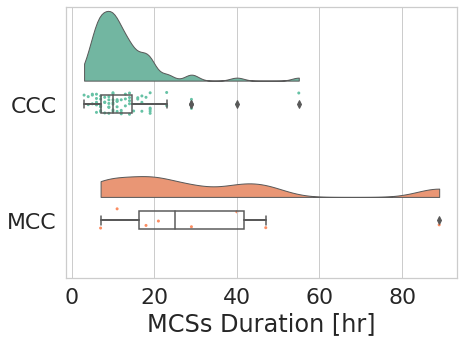

In [41]:
dx = list(c2["class"]); dy = list(c2["duration"]); ort = "h"; pal = "Set2";
sns.set(style="whitegrid",font_scale=2)
f, ax = plt.subplots(figsize=(7,5))
pt.RainCloud(x=dx,y=dy,data=c2, palette = pal, width_viol = 1.2, ax = ax, orient = ort)
#plt.xscale("log")
plt.xlabel('MCSs Duration [hr]')

## Genesis/Lysis Location by Class

### Add to c genesis/termination points by id so it they can be plotted by class

In [48]:
c2["lon_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.x)
c2["lon_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.x)
c2["lat_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.y)
c2["lat_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.y)


/glade/scratch/knocasio/ipykernel_281412/1288233134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2["lon_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.x)
/glade/scratch/knocasio/ipykernel_281412/1288233134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2["lon_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.x)
/glade/scratch/knocasio/ipykernel_281412/1288233134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

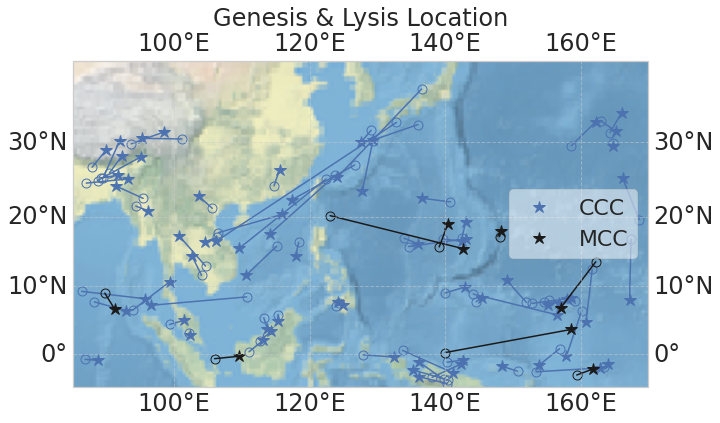

In [49]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

lon_min = tb.lon.min()
lon_max = tb.lon.max()
lat_min = tb.lat.min()
lat_max = tb.lat.max()

fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection=ccrs.Mercator())
ax.stock_img()   

#colors = {"CCC": "b", "DSL": "r", "MCC": "k", "DLL": "purple"}

#colors = {"DSL": "r", "DLL": "purple"}
colors = {"CCC": "b",  "MCC": "k"}
for class_, g in c2.groupby("class"):
    color = colors[class_]
    ax.plot(g.lon_in, g.lat_in, "*", transform=ccrs.PlateCarree(), markersize=12, label=class_, c=color)
    ax.plot([g.lon_in,g.lon_end], [g.lat_in,g.lat_end], "-", transform=ccrs.PlateCarree(), markersize=12, c=color)
    ax.plot(g.lon_end, g.lat_end, "o", transform=ccrs.PlateCarree(), markersize=9, mfc="none", c=color)

gridlines = ax.gridlines(draw_labels=True,alpha=0.5, linestyle='--')

plt.title('Genesis & Lysis Location')
plt.legend(framealpha=0.5)

extent = [lon_min, lon_max, lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())